<a href="https://colab.research.google.com/github/cleftwitch28/SOCL-PYQT5/blob/main/ANN_SOCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Define a simple ANN architecture
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 128)  # Assuming 3-channel (RGB) images of size 32x32
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  # 4 classes in Dataset

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Load  dataset
transform = transforms.Compose([
    transforms.Resize(32),  # Resize images to 32x32
    transforms.CenterCrop(32),  # Center crop to ensure 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.ImageFolder(
        root="/content/drive/MyDrive/Dataset/Train",
        transform=transform
    )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Initialize the model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 99:
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {loss.item():.4f}")

print("Training finished!")




Training finished!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

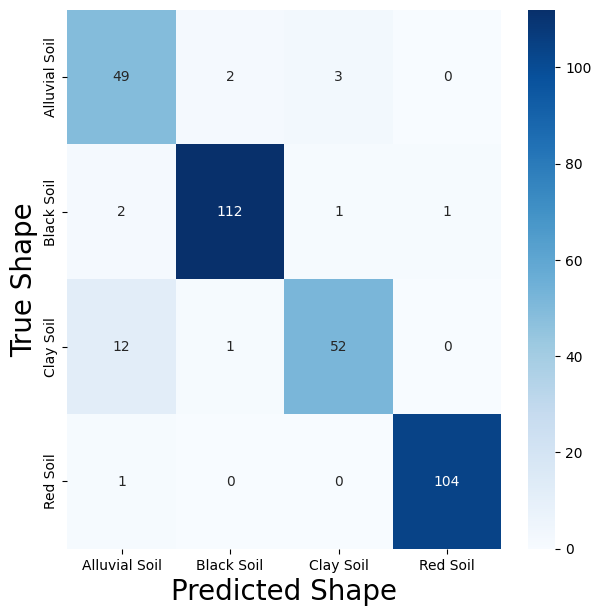

In [3]:
y_test="/content/drive/MyDrive/Dataset/test"

test_dataset = torchvision.datasets.ImageFolder(
        root=y_test,
        transform=transform
    )
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
true_labels = []
predictions = []
with torch.no_grad(): # No need to calculate gradients for evaluation
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
!pip  install torchmetrics
from torchmetrics.classification import MulticlassF1Score
true_labels_tensor = torch.tensor(true_labels)
predictions_tensor = torch.tensor(predictions)
num_classes = 4
f1_macro = MulticlassF1Score(num_classes=num_classes, average='weighted')
f1_macro.update(true_labels_tensor,predictions_tensor)
print(f"F1 score (weighted-average): {f1_macro.compute():.4f}")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Assuming 'y_test' contains ground truth labels and 'predictions' contains model predictions
cm = confusion_matrix(true_labels, predictions)
labels = ["Alluvial Soil","Black Soil","Clay Soil","Red Soil"]

df_cm = pd.DataFrame(cm, index = labels, columns = labels)
plt.figure(figsize = (7,7))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues, fmt='g')
plt.xlabel("Predicted Shape", fontsize = 20)
plt.ylabel("True Shape", fontsize = 20)
plt.show()


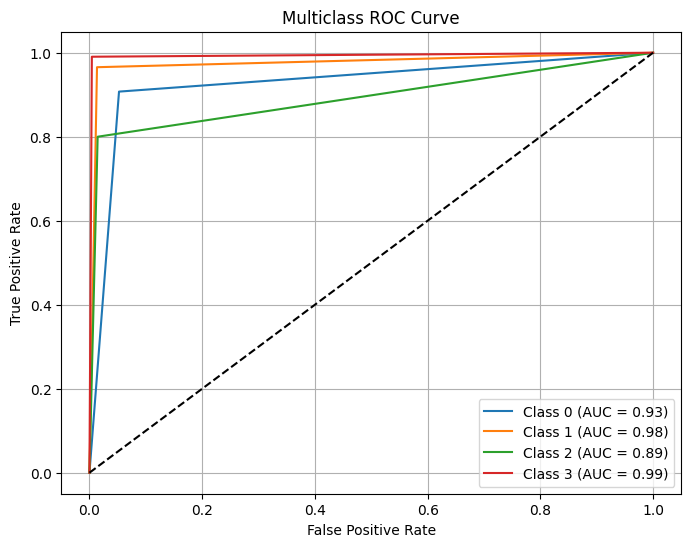

Multiclass AUROC: 0.9473


In [4]:
! pip install torchmetrics
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch
from torchmetrics.classification import MulticlassAUROC


y_score_onehot = torch.nn.functional.one_hot(torch.tensor(predictions), num_classes=4).float()


y_true = torch.tensor(true_labels)  # Replace with your ground truth

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score_onehot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot individual curves
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Add diagonal line
plt.plot([0, 1], [0, 1], 'k--')

# Customize plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid()

# Show the plot
plt.show()

metric = MulticlassAUROC(num_classes=4)
metric.update(y_score_onehot, y_true)
auroc = metric.compute()
print(f"Multiclass AUROC: {auroc:.4f}")


In [5]:
def Predict_class():
  inp="/content/drive/MyDrive/Dataset/test/Clay soil/Clay_4.jpg"
  from PIL import Image # Import Image from PIL to open image file
  img = Image.open(inp)
  transform = transforms.Compose([
    transforms.Resize(32),  # Resize images to 32x32
    transforms.CenterCrop(32),  # Center crop to ensure 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
  inp = transform(img)
  output=net(inp)
  print(output.argmax())
  if output.argmax() == 0:
      print("The given Image belongs to Alluvial Soil")
  elif output.argmax() == 1:
    print("The given Image belongs to Black Soil")
  elif output.argmax() == 2:
    print("The given Image belongs to Clay Soil")
  elif output.argmax() == 3:
    print("The given Image belongs to Red Soil")

Predict_class()

tensor(2)
The given Image belongs to Clay Soil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')